In [3]:
import numpy as np
import pandas as pd
from scipy.stats import t
import glob
import matplotlib.pyplot as plt

In [14]:
path = "C:\\Users\\Henry\\Documents\\data\\2020_04_11\\Trace\\"
all_files = glob.glob(path + "*.csv")
all_files

['C:\\Users\\Henry\\Documents\\data\\2020_05_23\\Trace\\trace_csf.csv',
 'C:\\Users\\Henry\\Documents\\data\\2020_05_23\\Trace\\trace_fly_remote.csv',
 'C:\\Users\\Henry\\Documents\\data\\2020_05_23\\Trace\\trace_jdbc.csv',
 'C:\\Users\\Henry\\Documents\\data\\2020_05_23\\Trace\\trace_local.csv',
 'C:\\Users\\Henry\\Documents\\data\\2020_05_23\\Trace\\trace_osb.csv',
 'C:\\Users\\Henry\\Documents\\data\\2020_05_23\\Trace\\trace_remote_process.csv']

In [15]:
dfs = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None)
    dfs.append(df)

In [16]:
for df in dfs:
    if df['callType'].iloc[0]=='JDBC' or df['callType'].iloc[0]=='LOCAL':
        df['serviceName'] = df['dsName']
    elif df['callType'].iloc[0]=='RemoteProcess' or df['callType'].iloc[0]=='OSB':
        df['serviceName'] = df['cmdb_id']

In [5]:
# df.head()

In [17]:
df = pd.concat(dfs, axis=0, ignore_index=True)
# df.head()

In [18]:
df = df.drop('dsName', axis=1)
# df = df.drop(['path'], axis=1)
# df.head()

In [37]:
anomaly_time = 1586542680000
df = df[(df.startTime >= (anomaly_time-1200000)) & (df.startTime <= (anomaly_time + 300000))]

In [38]:
df1 = df[df['callType']=='RemoteProcess']
df1 = df1[['pid','cmdb_id']]
df1 = df1.set_index('pid')

In [39]:
csf_cmdb = df1.to_dict()
csf_cmdb = {str(key):str(values) for key, values in csf_cmdb['cmdb_id'].items()}

In [40]:
from tqdm import tqdm
for index, row in tqdm(df.iterrows()):
    if row['id'] in csf_cmdb:
        df.at[index, 'serviceName'] = csf_cmdb[row['id']]

573337it [00:39, 14621.88it/s]


In [41]:
elapse_time = {}
children = {}
for index, row in tqdm(df.iterrows()):
    if row['pid'] != 'None':
        if row['pid'] in children.keys():
            children[row['pid']].append(row['id'])
        else:
            children[row['pid']] = [row['id']]
    elapse_time[row['id']] = float(row['elapsedTime'])

573337it [00:47, 12059.72it/s]


In [42]:
df['actual_time'] = 0.0
for index, row in tqdm(df.iterrows()):
    total_child = 0.0
    if row['id'] not in children.keys():
        df.at[index, 'actual_time'] = row['elapsedTime']
        continue
    for child in children[row['id']]:
        total_child += elapse_time[child]
    df.at[index, 'actual_time'] = row['elapsedTime'] - total_child

573337it [00:50, 11258.62it/s]


In [13]:
df = df.sort_values(['traceId','startTime','callType'], ignore_index = True)

In [25]:
df.serviceName.unique()

array(['docker_002', 'docker_008', 'docker_007', 'docker_003',
       'docker_005', 'docker_004', 'docker_006', 'docker_001',
       'fly_remote_001', 'db_003', 'db_009', 'db_007', 'os_022', 'os_021'],
      dtype=object)

In [43]:
df.head(60)

,callType,startTime,elapsedTime,success,traceId,id,pid,cmdb_id,serviceName,actual_time
33414,CSF,1590164400030,265.0,True,38171c538e4581e873ac,3817119c467581e973ac,381718b5a35581e873ac,os_022,docker_002,5.0
33415,CSF,1590164400039,263.0,True,38171aca8f2384f973ac,38171ae7b053847a73ac,381714bcff3384f973ac,os_022,docker_002,3.0
33416,CSF,1590164400046,39.0,True,38171c538e4581e873ac,381716b80c1715ea73ac,38171569a736152a73ac,docker_002,docker_008,5.0
33417,CSF,1590164400052,37.0,True,38171aca8f2384f973ac,38171d05c637154b73ac,38171619a776159a73ac,docker_002,docker_007,5.0
33418,CSF,1590164400087,26.0,True,38171c538e4581e873ac,381714925457157d73ac,38171569a736152a73ac,docker_002,docker_008,4.0
33419,CSF,1590164400091,24.0,True,38171aca8f2384f973ac,38171876927715ad73ac,38171619a776159a73ac,docker_002,docker_007,3.0
33420,CSF,1590164400094,225.0,True,38171e40ea04295c73ac,38171ff5575429ed73ac,3817139e8114295c73ac,os_021,docker_003,44.0
33421,CSF,1590164400109,35.0,True,38171e40ea04295c73ac,381716616b5543de73ac,381719b6a715432e73ac,docker_003,docker_005,3.0
33422,CSF,1590164400115,24.0,True,38171c538e4581e873ac,38171d957f97153f73ac,38171569a736152a73ac,docker_002,docker_007,5.0
33423,CSF,1590164400118,27.0,True,38171aca8f2384f973ac,381712593b18155f73ac,38171619a776159a73ac,docker_002,docker_008,4.0


In [44]:
grouped_df = df.groupby(['cmdb_id', 'serviceName'])[['startTime','actual_time']]

In [28]:
grouped_df.groups.keys()

dict_keys([('docker_001', 'db_007'), ('docker_001', 'db_009'), ('docker_001', 'docker_001'), ('docker_001', 'docker_007'), ('docker_001', 'docker_008'), ('docker_001', 'fly_remote_001'), ('docker_002', 'db_007'), ('docker_002', 'db_009'), ('docker_002', 'docker_002'), ('docker_002', 'docker_007'), ('docker_002', 'docker_008'), ('docker_002', 'fly_remote_001'), ('docker_003', 'db_007'), ('docker_003', 'db_009'), ('docker_003', 'docker_003'), ('docker_003', 'docker_005'), ('docker_003', 'docker_006'), ('docker_003', 'fly_remote_001'), ('docker_004', 'db_007'), ('docker_004', 'db_009'), ('docker_004', 'docker_004'), ('docker_004', 'docker_005'), ('docker_004', 'docker_006'), ('docker_004', 'fly_remote_001'), ('docker_005', 'db_003'), ('docker_005', 'docker_005'), ('docker_006', 'db_003'), ('docker_006', 'docker_006'), ('docker_007', 'db_003'), ('docker_007', 'docker_007'), ('docker_008', 'db_003'), ('docker_008', 'docker_008'), ('os_021', 'docker_003'), ('os_021', 'docker_004'), ('os_021'

In [45]:
def esd_test_statistics(x, hybrid=True):
  """
  Compute the location and dispersion sample statistics used to carry out the ESD test.
  """
  if hybrid:
    location = pd.Series(x).median(skipna=True) # Median
    dispersion = np.median(np.abs(x - np.median(x))) # Median Absolute Deviation
  else:  
    location = pd.Series(x).mean(skipna=True) # Mean
    dispersion = pd.Series(x).std(skipna=True) # Standard Deviation
    
  return location, dispersion    

In [46]:
# def seasonal_mean(x, freq):
#   """
#   Returns the mean of the timeseries for each period in x.
  
#   x    : List, array, or series containing the time series
#   freq : Int that gives the number of periods per cycle (7 for week, 12 for monthly, etc)
#   """
#   return np.array([pd.Series(x[i::freq]).mean(skipna=True) for i in range(freq)])

def ts_S_Md_decomposition(x):
  """
  Decomposes the timeseries using a modified STL method:Rx = X - Sx - X^~.
    Rx : Residuals
    X  : Original time series
    Sx : Seasonality component (average value per period)
    X^~: Median of original timeseries
    
  x    : List, array, or series containing the time series 
  freq : Int that gives the number of periods per cycle (7 for week, 12 for monthly, etc)  
  """
  nobs = len(x)
  
  # Seasonality
#   period_averages = seasonal_mean(x, freq)
#   seasonal = np.tile(period_averages, nobs // freq + 1)[:nobs]
  
  # Median
  med = np.tile(pd.Series(x).median(skipna=True), nobs)
  
  # Residuals
#   res = np.array(x) - seasonal - med
  res = np.array(x) - med
  return {"observed": np.array(x), "median":med, "residual":res}

In [47]:
def esd_test(x, alpha=0.95, ub=0.499, hybrid=True):
  """
  Carries out the Extreme Studentized Deviate(ESD) test which can be used to detect one or more outliers present in the timeseries
  
  x      : List, array, or series containing the time series
  freq   : Int that gives the number of periods per cycle (7 for week, 12 for monthly, etc)
  alpha  : Confidence level in detecting outliers
  ub     : Upper bound on the fraction of datapoints which can be labeled as outliers (<=0.499)
  hybrid : Whether to use the robust statistics (median, median absolute error) or the non-robust versions (mean, standard deviation) to test for anomalies
  """
  nobs = len(x)
  if ub > 0.4999:
    ub = 0.499
  k = max(int(np.floor(ub * nobs)), 1) # Maximum number of anomalies. At least 1 anomaly must be tested.
#   res_tmp = ts_S_Md_decomposition(x)["residual"] # Residuals from time series decomposition
    
  # Carry out the esd test k times  
  res = np.ma.array(x, mask=False) # The "ma" structure allows masking of values to exclude the elements from any calculation
  anomalies = [] # returns the indices of the found anomalies
  for i in range(1, k+1):
    location, dispersion = esd_test_statistics(res, hybrid) # Sample statistics
    tmp = np.abs(res - location) / dispersion
    idx = np.argmax(tmp) # Index of the test statistic
    test_statistic = tmp[idx] 
    n = nobs - res.mask.sum() # sums  nonmasked values
    critical_value = (n - i) * t.ppf(alpha, n - i - 1) / np.sqrt((n - i - 1 + np.power(t.ppf(alpha, n - i - 1), 2)) * (n - i - 1)) 
    if test_statistic > critical_value:
      anomalies.append(test_statistic)
    res.mask[idx] = True  
  return np.mean(anomalies)

In [48]:
grouped_df.groups.keys()

dict_keys([('docker_001', 'db_007'), ('docker_001', 'db_009'), ('docker_001', 'docker_001'), ('docker_001', 'docker_007'), ('docker_001', 'docker_008'), ('docker_001', 'fly_remote_001'), ('docker_002', 'db_007'), ('docker_002', 'db_009'), ('docker_002', 'docker_002'), ('docker_002', 'docker_007'), ('docker_002', 'docker_008'), ('docker_002', 'fly_remote_001'), ('docker_003', 'db_007'), ('docker_003', 'db_009'), ('docker_003', 'docker_003'), ('docker_003', 'docker_005'), ('docker_003', 'docker_006'), ('docker_003', 'fly_remote_001'), ('docker_004', 'db_007'), ('docker_004', 'db_009'), ('docker_004', 'docker_004'), ('docker_004', 'docker_005'), ('docker_004', 'docker_006'), ('docker_004', 'fly_remote_001'), ('docker_005', 'db_003'), ('docker_005', 'docker_005'), ('docker_006', 'db_003'), ('docker_006', 'docker_006'), ('docker_007', 'db_003'), ('docker_007', 'docker_007'), ('docker_008', 'db_003'), ('docker_008', 'docker_008'), ('os_021', 'docker_003'), ('os_021', 'docker_004'), ('os_021'

In [64]:
class RCA():
    def local_initiate(self):
        self.dockers = ['docker_001', 'docker_002', 'docker_003', 'docker_004',
                'docker_005', 'docker_006', 'docker_007', 'docker_008']
        self.docker_hosts = ['os_017', 'os_018', 'os_019', 'os_020']

        self.docker_kpi_names = ['container_cpu_used', None]
        self.os_kpi_names = ['Sent_queue', 'Received_queue']
        self.db_kpi_names = ['Proc_User_Used_Pct','Proc_Used_Pct','Sess_Connect','On_Off_State', 'tnsping_result_time']

        self.docker_lookup_table = {}
        for i in range(len(self.dockers)):
            self.docker_lookup_table[self.dockers[i]] = self.docker_hosts[i % 4]
            
    def find_anomalous_rows(self, min_threshold = 5):
        table = self.anomaly_chart.copy()
        threshold = max( 0.5 * table.stack().max(), min_threshold)
        dodgy_rows = []
        just_rows = []
        for column in table:
            v = 0
            r = ''
            for index, row in table.iterrows():
                if (row[column] > threshold):
                    if index == column:
                        dodgy_rows.append([index, row[column]])
                        just_rows.append(index)
                        break
                    elif (row[column] > v):
                        v = row[column]
                        r = index
            if r != '':
                dodgy_rows.append([r, column, v])
                just_rows.append(r)
        
        output = self.localize(dodgy_rows, list(set(just_rows)))
        return output


    def find_anomalous_kpi(self, cmdb_id):
        kpi_names = []
        if 'os' in cmdb_id:
            kpi_names = self.os_kpi_names
        elif 'docker' in cmdb_id:
            kpi_names = self.docker_kpi_names
        else:
            kpi_names = self.db_kpi_names

        return kpi_names


    def localize(self, dodgy_rows, just_rows):
        n = len(just_rows)
        if n < 1:
            return None
        if n == 1:
            KPIs = self.find_anomalous_kpi(just_rows[0])
            to_be_sent = []
            for KPI in KPIs:
                to_be_sent.append([just_rows[0], KPI])
            return to_be_sent
        if n == 2:
            r0 = just_rows[0]
            r1 = just_rows[1]
            if ('os' in r0) and ('os' in r1):
                KPI = self.find_anomalous_kpi('os_001')
                return [['os_001', KPI[0]],['os_001', KPI[1]]]
            elif ('docker' in r0) and ('docker' in r1):
                if self.docker_lookup_table[r0] == self.docker_lookup_table[r1]:
                    KPI = self.find_anomalous_kpi(self.docker_lookup_table[r0])
                    return [[self.docker_lookup_table[r0], KPI]]
            else:
                KPI0s = self.find_anomalous_kpi(r0)
                KPI1s = self.find_anomalous_kpi(r1)
                to_be_sent = []
                for kpi in KPI0s:
                    to_be_sent.append([r0, kpi])
                for kpi in KPI1s:
                    to_be_sent.append([r1, kpi])
                return to_be_sent
        if n > 2:
            dodgy_rows.sort(key = lambda x: x[2], reverse = True)
            just_rows = [x[0] for x in dodgy_rows]
            just_rows = list(set(just_rows))
            return self.localize(dodgy_rows[:2], just_rows[:2])

In [67]:
rca = RCA()
rca.local_initiate()
rca.anomaly_chart = anomaly_chart
output = rca.find_anomalous_rows()

In [68]:
output

[['db_003', 'Proc_User_Used_Pct'],
 ['db_003', 'Proc_Used_Pct'],
 ['db_003', 'Sess_Connect'],
 ['db_003', 'On_Off_State'],
 ['db_003', 'tnsping_result_time']]

In [55]:
anomaly_chart = pd.DataFrame()
for (a, b), value in grouped_df:
    value['time_group'] = value.startTime//60000
    value =value.groupby(['time_group'])['actual_time'].mean().reset_index()
    result = esd_test(value['actual_time'].to_numpy(), alpha=0.95, ub=0.02, hybrid=True)
    anomaly_chart.loc[b,a] = result
    # print(a,b,' = ',len(result)/len(value)*100)

In [56]:
anomaly_chart.sort_index(inplace=True)
anomaly_chart

,docker_001,docker_002,docker_003,docker_004,docker_005,docker_006,docker_007,docker_008,os_021,os_022
db_003,NaN,NaN,NaN,NaN,395.427476,506.735357,652.038611,1188.941582,NaN,NaN
db_007,5.078590,3.917711,3.055954,2.058739,NaN,NaN,NaN,NaN,NaN,NaN
db_009,4.547485,3.631238,6.373846,3.516092,NaN,NaN,NaN,NaN,NaN,NaN
docker_001,6.498043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.219788
docker_002,NaN,4.411082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.791206
docker_003,NaN,NaN,5.780308,NaN,NaN,NaN,NaN,NaN,5.07536,NaN
docker_004,NaN,NaN,NaN,5.462637,NaN,NaN,NaN,NaN,17.58280,NaN
docker_005,NaN,NaN,6.376907,4.268195,16.903471,NaN,NaN,NaN,NaN,NaN
docker_006,NaN,NaN,3.109623,3.324249,NaN,32.644674,NaN,NaN,NaN,NaN
docker_007,7.217820,3.794487,NaN,NaN,NaN,NaN,26.026669,NaN,NaN,NaN


In [50]:
test = grouped_df.get_group(('docker_008', 'docker_008'))

In [51]:
x = test[['startTime','actual_time']]
# x_val = x['actual_time'].to_numpy()
# x

In [52]:
x['time_group'] = x.startTime//10000
x = x.groupby(['time_group'])['actual_time'].mean().reset_index()

In [53]:
x_val = x['actual_time'].to_numpy()

In [54]:
result = esd_test(x_val, freq=3, alpha=0.99, ub=0.4, hybrid=True)

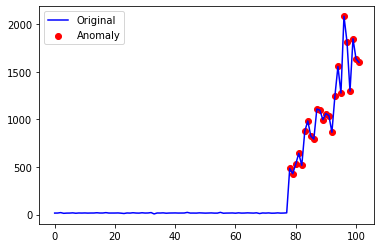

In [55]:
fig, ax = plt.subplots()
ax.plot(pd.Series(x_val).index, x_val, color="blue", label = "Original")
ax.scatter(result, x_val[result], color='red', label='Anomaly')
plt.legend(loc="best")
plt.show()

In [183]:
x = test[['startTime','actual_time']]
# x_val = x['actual_time'].to_numpy()
# x
x['time_group'] = x.startTime//1000
x = x.groupby(['time_group'])['actual_time'].mean().reset_index()

In [186]:
x_test = x.copy()
x_test.index = pd.to_datetime(x_test['time_group'], unit="s")

In [187]:
x_test

,time_group,actual_time
time_group,,
2020-05-25 18:04:00,1590429840,1.000000
2020-05-25 18:04:01,1590429841,0.814815
2020-05-25 18:04:02,1590429842,2.972222
2020-05-25 18:04:03,1590429843,1.093023
2020-05-25 18:04:04,1590429844,0.818182
...,...,...
2020-05-25 18:10:31,1590430231,5.802956
2020-05-25 18:10:32,1590430232,3.170213
2020-05-25 18:10:33,1590430233,0.648148
